In [15]:
import sys
sys.path.append("../src/")
import gc
import time
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from torch.optim.swa_utils import update_bn
import wandb

from util import *
from dataset import *
from models import get_model
from loss import get_loss
from metric import cal_mae_metric
from optim import get_optimizer
from util import *
from FE import add_features_choice
from dataset import read_data, prepare_train_valid, VPP, cls_2_num_func
from infer_helper import get_test_avg, get_cv_score
from config import read_config, update_config, prepare_args
from models import get_model
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
from torchsummary import summary

In [3]:
config = read_config("LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3")
config.gpu = [0]
config.train_folds = [0]
config = update_config(config)

Using device: cuda
Number of device: 1
Model Output Folder: /home/vincent/Kaggle/GBVPP/output/LSTM5_CLS_DO03_CH02_IPOnly_SiLU_ADAM_PL3/


In [4]:
train, test = read_data(config)
del test
train = add_features_choice(train.copy(), config)
seed_torch(seed=config.seed)

--- Generate u_out features ---
--- Generate time features ---
--- Generate u_in features ---
--- Generate cross sectional features ---
--- Generate physics features ---
--- Generate R C features ---
Drop Low Importance Columns: ['step', 'cross_time', 'expand_skew', 'expand_kurt']


In [6]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 2095.3216552734375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 1473.6 MB
This is 70.3% of the initial size


In [5]:
train.head()

,id,breath_id,time_step,u_in,u_out,pressure,fold,u_out_diff,u_out_diff_back1,u_out_diff_back2,...,C_50,R_C_20_10,R_C_20_20,R_C_20_50,R_C_50_10,R_C_50_20,R_C_50_50,R_C_5_10,R_C_5_20,R_C_5_50
0,1,1,0.000000,0.083334,0,5.837492,4,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,4,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509277,0,7.876254,4,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808823,0,11.742872,4,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,4,0.0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0


In [7]:
X_train, y_train, w_train, X_valid, y_valid, w_valid = prepare_train_valid(train.copy(), config, 1)
del X_train, y_train, w_train
gc.collect()

Prepare train valid
(6036000, 77)
Use scale to fit train and scale valid


0

In [8]:
valid_dt = VPP(X_valid, y_valid, w_valid, config)
valid_loader = DataLoader(valid_dt,
                          batch_size=config.batch_size,
                          shuffle=False,
                          num_workers=config.num_workers, pin_memory=True, drop_last=False)

In [9]:
def get_valid_pred(valid_loader, model, device):
    model.eval()
    preds = []
    for step, batch in enumerate(valid_loader, 1):
        with torch.no_grad():
            X = batch[0].to(device)
            outputs = model(X).squeeze()
            preds.append(outputs.to('cpu').detach().numpy())
    predictions = np.concatenate(preds, axis=0)
    return predictions

In [10]:
model = get_model(X_valid.shape[-1], config)
checkpoint = torch.load(f'{config.model_output_folder}/Fold_1_best_model.pth')
model.load_state_dict((checkpoint['model_state_dict']))
print("Model Size: {}".format(get_n_params(model)))
model.to(config.device)

Load Model Module BASE
Model Size: (7091648, 7091648)


Model(
  (rnns): ModuleList(
    (0): LSTM(73, 256, batch_first=True, bidirectional=True)
    (1): LSTM(512, 256, batch_first=True, bidirectional=True)
    (2): LSTM(512, 256, batch_first=True, bidirectional=True)
    (3): LSTM(512, 256, batch_first=True, bidirectional=True)
    (4): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (rnn_dos): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Dropout(p=0.3, inplace=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (rnn_bns): ModuleList(
    (0): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )

In [11]:
COLS = [col for col in train.columns if col not in ["id", "breath_id", "fold", "pressure"]]

In [16]:
results = []
print(' Computing LSTM feature importance...')
# COMPUTE BASELINE (NO SHUFFLE)
oof_preds = get_valid_pred(valid_loader, model, config.device)

if not config.do_reg:
    oof_preds = cls_2_num_func(oof_preds.argmax(axis=-1), config.pressure_unique_path)

baseline_mae = (np.abs( oof_preds-y_valid ) * w_valid).sum()/w_valid.sum()
results.append({'feature':'BASELINE','mae':baseline_mae})           
print(baseline_mae)

 Computing LSTM feature importance...
0.16898595804802533


In [18]:
for k in tqdm(range(len(COLS))):
    # SHUFFLE FEATURE K
    save_col = X_valid[:,:,k].copy()
    np.random.shuffle(X_valid[:,:,k])
    valid_dt = VPP(X_valid, y_valid, w_valid, config)
    valid_loader = DataLoader(valid_dt,
                              batch_size=config.batch_size,
                              shuffle=False,
                              num_workers=config.num_workers, pin_memory=True, drop_last=False)    
    # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
    oof_preds = get_valid_pred(valid_loader, model, config.device)
    if not config.do_reg:
        oof_preds = cls_2_num_func(oof_preds.argmax(axis=-1), config.pressure_unique_path)    
    mae = (np.abs( oof_preds-y_valid ) * w_valid).sum()/w_valid.sum()
    results.append({'feature':COLS[k],'mae':mae})
    X_valid[:,:,k] = save_col

100%|███████████████████████████████████████████████████████████████████████████| 73/73 [13:16<00:00, 10.91s/it]


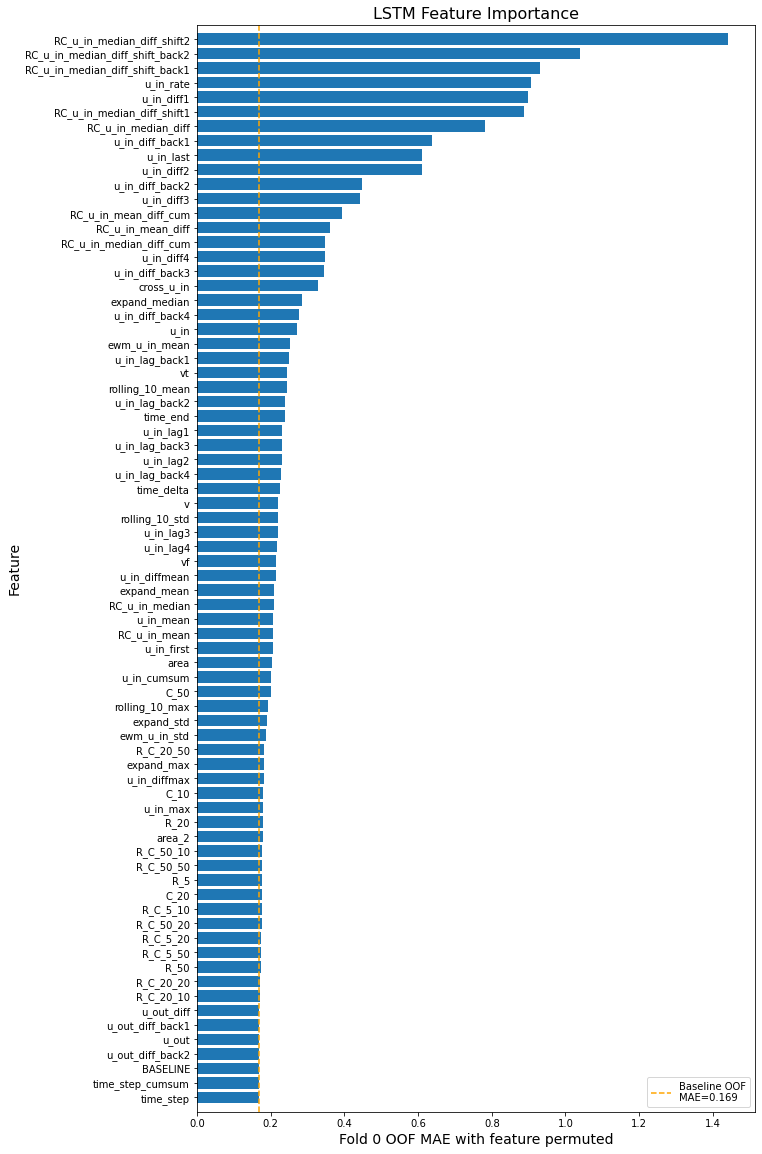

In [19]:
# DISPLAY LSTM FEATURE IMPORTANCE
print()
df = pd.DataFrame(results)
df = df.sort_values('mae')
plt.figure(figsize=(10,20))
plt.barh(np.arange(len(COLS)+1),df.mae)
plt.yticks(np.arange(len(COLS)+1),df.feature.values)
plt.title('LSTM Feature Importance',size=16)
plt.ylim((-1,len(COLS)+1))
plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
         label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
plt.xlabel(f'Fold 0 OOF MAE with feature permuted',size=14)
plt.ylabel('Feature',size=14)
plt.legend()
plt.show()

# SAVE LSTM FEATURE IMPORTANCE

df = df.sort_values('mae',ascending=False)
df.to_csv(f'../output/lstm_update_feature_importance_fold_1.csv',index=False)

In [20]:
df

,feature,mae
51,RC_u_in_median_diff_shift2,1.442087
52,RC_u_in_median_diff_shift_back2,1.038786
50,RC_u_in_median_diff_shift_back1,0.929712
53,u_in_rate,0.907649
14,u_in_diff1,0.898630
...,...,...
3,u_out,0.169052
6,u_out_diff_back2,0.169041
0,BASELINE,0.168986
55,time_step_cumsum,0.168940


In [15]:
train, test = read_data(config)